
## References
* [Probability Calibration curves example](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py)
* [Why Model Calibration Matters and How](https://www.unofficialgoogledatascience.com/2021/04/why-model-calibration-matters-and-how.html)
* [Predicting Good Probabilities with Supervised Learning](https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf)
* [Classification: Prediction Bias](https://developers.google.com/machine-learning/crash-course/classification/prediction-bias)
* [Calibration by Andreas Muller](https://www.youtube.com/watch?v=w3OPq0V8fr8)
    * [Slides](https://amueller.github.io/COMS4995-s20/slides/aml-10-calibration-imbalanced-data/#2)


## To Add
* Explanation (Just use Muller's lecture to quickly explain)
* XGBoost, LightGBM, Random Forest

## What is probability calibration? What does it mean for a forecast to be well calibrated?

The goal of supervised machine learning models is to predict outcomes of new data. One type of prediction that such models can make are values that may be interpreted as the  probabilities. Probability calibration is concerned with calibrated if out of all the times the model said that there was a 40 percent chance of rain, rain did actually fall 40 percent of the time? [source: Google Blog]

Out of all the records where P(Y|X) = 0.6, do we actually see that there 60% of these records are positive classes. Similarly, for all records where P(Y|X) = 0.2, are 20% of the records in this subset actually positive classes?

Examples:

* Spam vs not spam: 
* Rain
* 

## Why might we care about probability predictions over classification
* Using the prediction as a score to rank which customers to target in marketing campaign, then no calibration is required. However, if the predictions will be used to compute say expected revenue, then the model's predicton should be calibrated
* Model modularity ??? (Google Blog)
* Which one would you rather hear: the model predicted you don't have cancer or the model predicted you're 40% likely to have cancer? [Mueller]

## Why do classification models become miscalibrated?

## Which algorithms require calibration?

## How do you calibrate model predictions?
* 1-d regression model that maps the predicted probabilities to the 45 degree line in predicted probability / fraction of true positive plots (Muller, 23:00)

### How are LightGBM and Random Forest calibrated?
### Why do RF models have an S shaped???
- Muller video at 16:00 mark

## Notes
* It is possible to have a well-calibrated but useless model
    * If 40% of the customers churned in the data, we can use the model P(Churn) = 0.4 for each customer
    * This model is perfectly calibrated: when it predicts 0.4 and 40% of our customers actually churned
    * But this model cannot explain the prediction: P(Churn|X) = P(Churn). It cannot rank the customers in our dataset by their probability of churning.
    * Thus it is possible to have well-calibrated but useless models
* It is possible to have poorly calibrated but fuseful model
    * RF is a poorly calibrated but useful model: it can rank customers by their probability of churning but will underestimate probability of churn for predictions <50% and overestimate it for predictions >50% (See Muller lecture)
    * Why does it do this ???

In [19]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.calibration import CalibratedClassifierCV, calibration_curve # ???
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, # ???
                             precision_score, 
                             recall_score,
                             f1_score)

In [20]:
# Create dataset

X, y = datasets.make_classification(n_samples=100_000, n_features=20,
                                    n_informative=2, n_redundant=10,  # ???
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)
X, y

(array([[ 1.02259257,  0.65552289,  1.32683445, ...,  0.98226539,
         -0.90752137,  1.96446595],
        [ 0.97335244,  1.03796284, -0.17722698, ..., -2.11697771,
         -1.19228631, -1.18217862],
        [-1.38826145, -0.26109172,  0.74907354, ...,  2.42458899,
          0.73313171,  0.66861941],
        ...,
        [ 0.7384264 ,  1.3236177 ,  0.58745182, ...,  0.50154538,
         -1.32991078, -0.14465644],
        [ 1.34634369, -0.30804254,  0.52594723, ...,  0.39934833,
         -0.26570879,  0.22887331],
        [-0.18860303,  0.98776555,  0.17847475, ..., -0.43722285,
         -0.7122176 , -1.81358672]]),
 array([0, 1, 0, ..., 1, 1, 0]))

In [21]:
clf = LogisticRegression(C=1.)
clf.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
prob_pos = clf.predict_proba(X_test)[:, 1]

In [23]:
clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())  # metric for evaluating calibration performance
fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

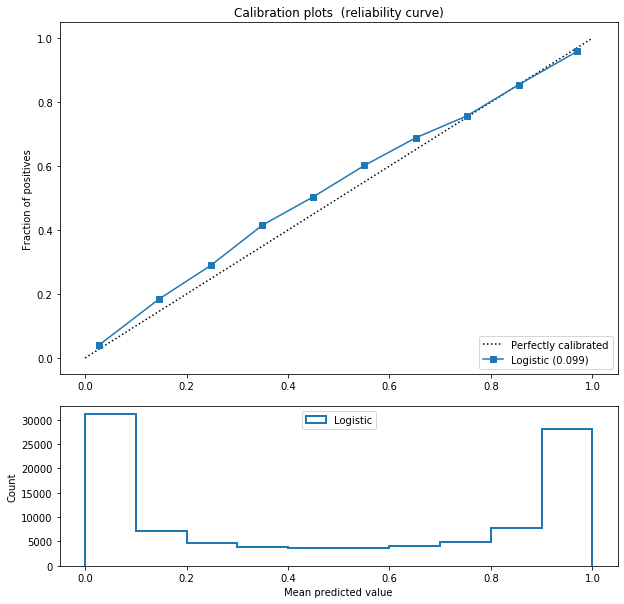

In [26]:
name = 'Logistic'


fig_index=1
fig = plt.figure(fig_index, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

# Plot perfectly calibrated curve (45 degree line)
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="%s (%1.3f)" % (name, clf_score))

ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
         histtype="step", lw=2)

# Figure formatting
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)